In [24]:
!pip install fastf1 pandas numpy scikit-learn matplotlib seaborn requests optuna lightgbm prophet feature-engine

In [27]:
import os
import fastf1
import pandas as pd
import numpy as np
import requests
import optuna
import lightgbm as lgb
from prophet import Prophet
from feature_engine.selection import SmartCorrelatedSelection
from feature_engine.creation import CyclicalFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt
import seaborn as sns

# Setup FastF1 cache
os.makedirs("f1_cache", exist_ok=True)
fastf1.Cache.enable_cache("f1_cache")

# Load historical data
def load_historical_data():
    sessions = []
    try:
        # Only load Emilia Romagna GP data from 2024
        session = fastf1.get_session(2024, "Emilia Romagna", "R")
        session.load()
        sessions.append(session)
    except Exception as e:
        print(f"Error loading Emilia Romagna GP data: {e}")
    return sessions



In [28]:
def extract_features(sessions):
    all_laps = []
    for session in sessions:
        # Extract more track-specific features
        laps = session.laps[["Driver", "LapTime", "Sector1Time", "Sector2Time",
                           "Sector3Time", "TrackStatus", "TyreLife", "Compound",
                           "Position", "LapNumber", "PitOutTime", "PitInTime"]].copy()

        # Add session date to each lap
        laps['datetime'] = pd.to_datetime(session.date)
        laps["Session"] = f"{session.event.year}_{session.event.name}"

        # Add pit stop impact
        laps["PitStop"] = (~pd.isnull(laps["PitOutTime"]) | ~pd.isnull(laps["PitInTime"])).astype(int)

        # Track position impact
        laps["TrackPosition"] = laps["Position"] / laps["Position"].max()

        # Lap progression feature
        laps["LapProgression"] = laps["LapNumber"] / laps["LapNumber"].max()

        all_laps.append(laps)

    combined_laps = pd.concat(all_laps)
    combined_laps.dropna(subset=["LapTime", "Sector1Time", "Sector2Time", "Sector3Time"], inplace=True)

    # Convert timedelta to seconds
    time_cols = ["LapTime", "Sector1Time", "Sector2Time", "Sector3Time"]
    for col in time_cols:
        combined_laps[f"{col}_seconds"] = combined_laps[col].dt.total_seconds()

    return combined_laps



In [29]:
def create_driver_features():
    return pd.DataFrame({
        "Driver": ["VER", "NOR", "PIA", "LEC", "RUS", "HAM", "GAS", "ALO", "TSU",
                  "SAI", "HUL", "OCO", "STR"],
        "QualifyingTime": [80.423, 80.267, 79.841, 80.175, 80.009, 80.772, 80.216,
                          81.886, 81.303, 80.680, 82.067, 81.886, 82.283],
        "WetPerformance": [0.975, 0.976, 0.974, 0.975, 0.968, 0.976, 0.978, 0.972,
                          0.996, 0.978, 0.981, 0.981, 0.979],
        "SeasonPoints": [61, 62, 80, 20, 20, 20, 20, 20, 20, 20, 2, 8, 11],
        "Experience": [9, 5, 2, 7, 5, 17, 7, 19, 4, 6, 13, 8, 7],
        # Add Imola-specific performance metrics
        "ImolaPodiums": [3, 1, 0, 2, 0, 4, 0, 2, 0, 1, 0, 0, 0],
        "ImolaAvgFinish": [2.1, 4.2, 8.0, 3.8, 6.5, 3.2, 7.8, 4.5, 9.2, 5.1, 11.3, 10.8, 12.1]
    })

def get_weather_forecast(api_key):
    # Imola circuit coordinates
    lat, lon = 44.3439, 11.7167
    url = f"http://api.openweathermap.org/data/2.5/forecast?lat={lat}&lon={lon}&appid={api_key}&units=metric"

    try:
        response = requests.get(url)
        data = response.json()
        forecast = pd.DataFrame(data['list'])
        # Convert timestamp to datetime and rename to match our format
        forecast['datetime'] = pd.to_datetime(forecast['dt'], unit='s')
        forecast['temp'] = forecast.apply(lambda x: x['main']['temp'], axis=1)
        forecast['humidity'] = forecast.apply(lambda x: x['main']['humidity'], axis=1)
        forecast['wind_speed'] = forecast.apply(lambda x: x['wind']['speed'], axis=1)
        forecast['rain_prob'] = forecast['pop']

        # Round datetime to nearest hour for better matching
        forecast['datetime'] = forecast['datetime'].dt.round('H')

        # Keep only needed columns
        forecast = forecast[['datetime', 'temp', 'humidity', 'wind_speed', 'rain_prob']]
        return forecast
    except Exception as e:
        print(f"Weather forecast error: {e}")
        return None



In [30]:
def objective(trial, X_train, y_train, X_val, y_val):
    params = {
        'objective': 'regression',
        'metric': 'mae',
        'boosting_type': 'gbdt',
        'num_leaves': trial.suggest_int('num_leaves', 20, 100),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.4, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'verbosity': -1  # Suppress training output
    }

    # Create training and validation datasets
    train_data = lgb.Dataset(X_train, label=y_train)
    valid_data = lgb.Dataset(X_val, label=y_val, reference=train_data)

    # Train the model with early stopping
    model = lgb.train(
        params,
        train_data,
        valid_sets=[valid_data],
        num_boost_round=1000,
        callbacks=[
            lgb.early_stopping(stopping_rounds=50),
            lgb.log_evaluation(period=-1)  # Suppress evaluation output
        ]
    )

    # Get predictions using best iteration
    preds = model.predict(X_val, num_iteration=model.best_iteration)
    mae = mean_absolute_error(y_val, preds)
    return mae



core           INFO 	Loading data for Emilia Romagna Grand Prix - Race [v3.5.3]
INFO:fastf1.fastf1.core:Loading data for Emilia Romagna Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
INFO:fastf1.fastf1.req:Using cached data for session_info
req            INFO 	Using cached data for driver_info
INFO:fastf1.fastf1.req:Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
INFO:fastf1.fastf1.req:Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
INFO:fastf1.fastf1.req:Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
INFO:fastf1.fastf1.req:Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
INFO:fastf1.fastf1.req:Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
INFO:fastf1.fastf1.req:Using cached data for timing_app_data

Weather forecast error: 'list'
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[100]	valid_0's l1: 1.12701
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[24]	valid_0's l1: 1.21149
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[39]	valid_0's l1: 1.22318
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[5]	valid_0's l1: 1.25485
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[54]	valid_0's l1: 1.162
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[118]	valid_0's l1: 1.13874
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	valid_0's l1: 1.32615
Training until validation scores don't improve for 50 rounds


<ipython-input-30-936ca12ff7ff>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
<ipython-input-30-936ca12ff7ff>:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
<ipython-input-30-936ca12ff7ff>:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.4, 1.0),
[I 2025-05-29 05:53:26,973] Trial 7 finished with value: 1.1599953044579938 and parameters: {

Early stopping, best iteration is:
[256]	valid_0's l1: 1.16
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[20]	valid_0's l1: 1.2383
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[96]	valid_0's l1: 1.14502
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[24]	valid_0's l1: 1.15711
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[106]	valid_0's l1: 1.13808


<ipython-input-30-936ca12ff7ff>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
<ipython-input-30-936ca12ff7ff>:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
<ipython-input-30-936ca12ff7ff>:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.4, 1.0),
[I 2025-05-29 05:53:27,212] Trial 12 finished with value: 1.1251091600761984 and parameters: 

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[100]	valid_0's l1: 1.12511
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[35]	valid_0's l1: 1.16555
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[54]	valid_0's l1: 1.12506
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[54]	valid_0's l1: 1.13507


<ipython-input-30-936ca12ff7ff>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
<ipython-input-30-936ca12ff7ff>:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
<ipython-input-30-936ca12ff7ff>:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.4, 1.0),
[I 2025-05-29 05:53:27,442] Trial 16 finished with value: 1.2147183049949082 and parameters: 

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[8]	valid_0's l1: 1.21472
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[102]	valid_0's l1: 1.12296
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[17]	valid_0's l1: 1.15937
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[85]	valid_0's l1: 1.12639


<ipython-input-30-936ca12ff7ff>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
<ipython-input-30-936ca12ff7ff>:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
<ipython-input-30-936ca12ff7ff>:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.4, 1.0),
[I 2025-05-29 05:53:27,693] Trial 20 finished with value: 1.142706745294317 and parameters: {

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[240]	valid_0's l1: 1.14271
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[136]	valid_0's l1: 1.12903
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[108]	valid_0's l1: 1.16426


<ipython-input-30-936ca12ff7ff>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
<ipython-input-30-936ca12ff7ff>:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
<ipython-input-30-936ca12ff7ff>:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.4, 1.0),
[I 2025-05-29 05:53:27,909] Trial 23 finished with value: 1.1858786468864593 and parameters: 

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[24]	valid_0's l1: 1.18588
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[105]	valid_0's l1: 1.15679
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[124]	valid_0's l1: 1.13064


[I 2025-05-29 05:53:28,113] Trial 26 finished with value: 1.1541986025460123 and parameters: {'num_leaves': 93, 'learning_rate': 0.03355719368298435, 'feature_fraction': 0.5950921744324178, 'bagging_fraction': 0.9445300239461768, 'bagging_freq': 6, 'min_child_samples': 98}. Best is trial 17 with value: 1.1229645139128095.
<ipython-input-30-936ca12ff7ff>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
<ipython-input-30-936ca12ff7ff>:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
<ipython-input-30-936ca12ff7ff>:9: FutureWarning: suggest_uniform 

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[86]	valid_0's l1: 1.1542
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[127]	valid_0's l1: 1.16282
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[33]	valid_0's l1: 1.20792
Training until validation scores don't improve for 50 rounds


<ipython-input-30-936ca12ff7ff>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
<ipython-input-30-936ca12ff7ff>:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
<ipython-input-30-936ca12ff7ff>:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.4, 1.0),
[I 2025-05-29 05:53:28,314] Trial 29 finished with value: 1.2124282796266797 and parameters: 

Early stopping, best iteration is:
[74]	valid_0's l1: 1.21243
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[35]	valid_0's l1: 1.1043
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[37]	valid_0's l1: 1.05357


<ipython-input-30-936ca12ff7ff>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
<ipython-input-30-936ca12ff7ff>:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
<ipython-input-30-936ca12ff7ff>:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.4, 1.0),
[I 2025-05-29 05:53:28,546] Trial 32 finished with value: 1.0338749994054952 and parameters: 

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[39]	valid_0's l1: 1.03387
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[22]	valid_0's l1: 1.03688
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[29]	valid_0's l1: 1.04024


<ipython-input-30-936ca12ff7ff>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
<ipython-input-30-936ca12ff7ff>:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
<ipython-input-30-936ca12ff7ff>:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.4, 1.0),
[I 2025-05-29 05:53:28,759] Trial 35 finished with value: 1.0443860512467116 and parameters: 

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[18]	valid_0's l1: 1.04439
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[18]	valid_0's l1: 1.04492
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[37]	valid_0's l1: 0.965934


<ipython-input-30-936ca12ff7ff>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
<ipython-input-30-936ca12ff7ff>:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
<ipython-input-30-936ca12ff7ff>:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.4, 1.0),
[I 2025-05-29 05:53:28,975] Trial 38 finished with value: 0.9427366125548355 and parameters: 

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[23]	valid_0's l1: 0.942737
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[23]	valid_0's l1: 0.926925
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[27]	valid_0's l1: 0.923372


<ipython-input-30-936ca12ff7ff>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
<ipython-input-30-936ca12ff7ff>:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
<ipython-input-30-936ca12ff7ff>:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.4, 1.0),
[I 2025-05-29 05:53:29,195] Trial 41 finished with value: 0.9543863365897228 and parameters: 

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[20]	valid_0's l1: 0.954386
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[23]	valid_0's l1: 0.92648
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[72]	valid_0's l1: 0.774702


[I 2025-05-29 05:53:29,381] Trial 43 finished with value: 0.7747019014620172 and parameters: {'num_leaves': 37, 'learning_rate': 0.07373524309495044, 'feature_fraction': 0.48629998396328916, 'bagging_fraction': 0.9660005727772315, 'bagging_freq': 7, 'min_child_samples': 5}. Best is trial 43 with value: 0.7747019014620172.
<ipython-input-30-936ca12ff7ff>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
<ipython-input-30-936ca12ff7ff>:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
<ipython-input-30-936ca12ff7ff>:9: FutureWarning: suggest_uniform 

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[47]	valid_0's l1: 0.761899
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[45]	valid_0's l1: 0.756678
Training until validation scores don't improve for 50 rounds


<ipython-input-30-936ca12ff7ff>:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
<ipython-input-30-936ca12ff7ff>:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.4, 1.0),
[I 2025-05-29 05:53:29,715] Trial 46 finished with value: 0.7464459280054484 and parameters: {'num_leaves': 34, 'learning_rate': 0.07695824641881824, 'feature_fraction': 0.4577180939242049, 'bagging_fraction': 0.8859573300221906, 'bagging_freq': 1, 'min_child_samples': 5}. Best is trial 46 with value: 0.7464459280054484.
<ipython-input-30-936ca12ff7ff>:7: FutureWarning: suggest_loguniform has been depre

Early stopping, best iteration is:
[105]	valid_0's l1: 0.746446
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[59]	valid_0's l1: 0.740649
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[68]	valid_0's l1: 0.724017


<ipython-input-30-936ca12ff7ff>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
<ipython-input-30-936ca12ff7ff>:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
<ipython-input-30-936ca12ff7ff>:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.4, 1.0),
[I 2025-05-29 05:53:29,981] Trial 49 finished with value: 0.720397511588172 and parameters: {

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[68]	valid_0's l1: 0.720398
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[11]	valid_0's l1: 0.935704
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[47]	valid_0's l1: 0.749426


<ipython-input-30-936ca12ff7ff>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
<ipython-input-30-936ca12ff7ff>:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
<ipython-input-30-936ca12ff7ff>:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.4, 1.0),
[I 2025-05-29 05:53:30,209] Trial 52 finished with value: 0.9144542890967531 and parameters: 

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[23]	valid_0's l1: 0.914454
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[17]	valid_0's l1: 0.943495
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[68]	valid_0's l1: 0.708338


<ipython-input-30-936ca12ff7ff>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
<ipython-input-30-936ca12ff7ff>:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
<ipython-input-30-936ca12ff7ff>:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.4, 1.0),
[I 2025-05-29 05:53:30,497] Trial 55 finished with value: 0.6924384000224034 and parameters: 

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[90]	valid_0's l1: 0.692438
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[52]	valid_0's l1: 1.00191


<ipython-input-30-936ca12ff7ff>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
<ipython-input-30-936ca12ff7ff>:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
<ipython-input-30-936ca12ff7ff>:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.4, 1.0),
[I 2025-05-29 05:53:30,714] Trial 57 finished with value: 0.786997991425132 and parameters: {

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[120]	valid_0's l1: 0.786998
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[108]	valid_0's l1: 0.696808


<ipython-input-30-936ca12ff7ff>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
<ipython-input-30-936ca12ff7ff>:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
<ipython-input-30-936ca12ff7ff>:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.4, 1.0),
[I 2025-05-29 05:53:30,895] Trial 59 finished with value: 0.9470331572233938 and parameters: 

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[45]	valid_0's l1: 0.947033
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[184]	valid_0's l1: 0.838002


[I 2025-05-29 05:53:31,074] Trial 60 finished with value: 0.8380024139341063 and parameters: {'num_leaves': 29, 'learning_rate': 0.053258757412300003, 'feature_fraction': 0.46521403869568273, 'bagging_fraction': 0.9622551674756119, 'bagging_freq': 2, 'min_child_samples': 9}. Best is trial 55 with value: 0.6924384000224034.
<ipython-input-30-936ca12ff7ff>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
<ipython-input-30-936ca12ff7ff>:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
<ipython-input-30-936ca12ff7ff>:9: FutureWarning: suggest_uniform

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[114]	valid_0's l1: 0.84003
Training until validation scores don't improve for 50 rounds


[I 2025-05-29 05:53:31,569] Trial 62 finished with value: 0.8435551774260502 and parameters: {'num_leaves': 33, 'learning_rate': 0.08884350621127073, 'feature_fraction': 0.4224167085088054, 'bagging_fraction': 0.9291152800983188, 'bagging_freq': 2, 'min_child_samples': 14}. Best is trial 55 with value: 0.6924384000224034.


Early stopping, best iteration is:
[460]	valid_0's l1: 0.843555
Training until validation scores don't improve for 50 rounds


<ipython-input-30-936ca12ff7ff>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
<ipython-input-30-936ca12ff7ff>:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
<ipython-input-30-936ca12ff7ff>:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.4, 1.0),
[I 2025-05-29 05:53:31,709] Trial 63 finished with value: 0.9529816871612927 and parameters: 

Early stopping, best iteration is:
[143]	valid_0's l1: 0.952982
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[20]	valid_0's l1: 1.40545
Training until validation scores don't improve for 50 rounds


<ipython-input-30-936ca12ff7ff>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
<ipython-input-30-936ca12ff7ff>:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
<ipython-input-30-936ca12ff7ff>:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.4, 1.0),
[I 2025-05-29 05:53:31,928] Trial 65 finished with value: 0.7965001296194312 and parameters: 

Early stopping, best iteration is:
[143]	valid_0's l1: 0.7965
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[105]	valid_0's l1: 0.868468
Training until validation scores don't improve for 50 rounds


<ipython-input-30-936ca12ff7ff>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
<ipython-input-30-936ca12ff7ff>:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
<ipython-input-30-936ca12ff7ff>:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.4, 1.0),
[I 2025-05-29 05:53:32,126] Trial 67 finished with value: 1.6994183194951376 and parameters: 

Early stopping, best iteration is:
[3]	valid_0's l1: 1.69942
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[39]	valid_0's l1: 1.6083
Training until validation scores don't improve for 50 rounds


[I 2025-05-29 05:53:32,821] Trial 69 finished with value: 0.8475614917254564 and parameters: {'num_leaves': 50, 'learning_rate': 0.04127097642085724, 'feature_fraction': 0.4007409780118148, 'bagging_fraction': 0.9984098046726725, 'bagging_freq': 2, 'min_child_samples': 13}. Best is trial 55 with value: 0.6924384000224034.


Early stopping, best iteration is:
[735]	valid_0's l1: 0.847561


<ipython-input-30-936ca12ff7ff>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
<ipython-input-30-936ca12ff7ff>:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
<ipython-input-30-936ca12ff7ff>:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.4, 1.0),
[I 2025-05-29 05:53:32,965] Trial 70 finished with value: 0.8193279445478335 and parameters: 

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[126]	valid_0's l1: 0.819328
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[117]	valid_0's l1: 0.973827


[I 2025-05-29 05:53:33,103] Trial 71 finished with value: 0.9738270253045936 and parameters: {'num_leaves': 26, 'learning_rate': 0.07950045086203184, 'feature_fraction': 0.4487658603093061, 'bagging_fraction': 0.897217249667248, 'bagging_freq': 1, 'min_child_samples': 5}. Best is trial 55 with value: 0.6924384000224034.
<ipython-input-30-936ca12ff7ff>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
<ipython-input-30-936ca12ff7ff>:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
<ipython-input-30-936ca12ff7ff>:9: FutureWarning: suggest_uniform ha

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[248]	valid_0's l1: 0.93252
Training until validation scores don't improve for 50 rounds


[I 2025-05-29 05:53:33,581] Trial 73 finished with value: 0.8117546574321439 and parameters: {'num_leaves': 31, 'learning_rate': 0.0936471925751325, 'feature_fraction': 0.44016197822792574, 'bagging_fraction': 0.8679187983901498, 'bagging_freq': 2, 'min_child_samples': 11}. Best is trial 55 with value: 0.6924384000224034.


Early stopping, best iteration is:
[339]	valid_0's l1: 0.811754
Training until validation scores don't improve for 50 rounds


<ipython-input-30-936ca12ff7ff>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
<ipython-input-30-936ca12ff7ff>:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
<ipython-input-30-936ca12ff7ff>:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.4, 1.0),
[I 2025-05-29 05:53:33,835] Trial 74 finished with value: 0.7803276588499324 and parameters: 

Early stopping, best iteration is:
[296]	valid_0's l1: 0.780327
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[14]	valid_0's l1: 1.4727
Training until validation scores don't improve for 50 rounds


<ipython-input-30-936ca12ff7ff>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
<ipython-input-30-936ca12ff7ff>:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
<ipython-input-30-936ca12ff7ff>:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.4, 1.0),
[I 2025-05-29 05:53:34,150] Trial 76 finished with value: 0.9263440084270869 and parameters: 

Early stopping, best iteration is:
[366]	valid_0's l1: 0.926344
Training until validation scores don't improve for 50 rounds


<ipython-input-30-936ca12ff7ff>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
<ipython-input-30-936ca12ff7ff>:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
<ipython-input-30-936ca12ff7ff>:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.4, 1.0),
[I 2025-05-29 05:53:34,369] Trial 77 finished with value: 0.8291877838537971 and parameters: 

Early stopping, best iteration is:
[311]	valid_0's l1: 0.829188
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[20]	valid_0's l1: 1.43461
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[14]	valid_0's l1: 1.44997


<ipython-input-30-936ca12ff7ff>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
<ipython-input-30-936ca12ff7ff>:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
<ipython-input-30-936ca12ff7ff>:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.4, 1.0),


Training until validation scores don't improve for 50 rounds


[I 2025-05-29 05:53:34,840] Trial 80 finished with value: 0.7865388446028595 and parameters: {'num_leaves': 22, 'learning_rate': 0.0723241892245103, 'feature_fraction': 0.553558419660265, 'bagging_fraction': 0.8518512680413199, 'bagging_freq': 3, 'min_child_samples': 15}. Best is trial 55 with value: 0.6924384000224034.


Early stopping, best iteration is:
[452]	valid_0's l1: 0.786539
Training until validation scores don't improve for 50 rounds


<ipython-input-30-936ca12ff7ff>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
<ipython-input-30-936ca12ff7ff>:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
<ipython-input-30-936ca12ff7ff>:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.4, 1.0),
[I 2025-05-29 05:53:35,028] Trial 81 finished with value: 0.886060786315833 and parameters: {

Early stopping, best iteration is:
[179]	valid_0's l1: 0.886061
Training until validation scores don't improve for 50 rounds


[I 2025-05-29 05:53:35,248] Trial 82 finished with value: 0.8650903289331149 and parameters: {'num_leaves': 31, 'learning_rate': 0.07646729735537956, 'feature_fraction': 0.40498981947570883, 'bagging_fraction': 0.8743626917238102, 'bagging_freq': 1, 'min_child_samples': 11}. Best is trial 55 with value: 0.6924384000224034.
<ipython-input-30-936ca12ff7ff>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
<ipython-input-30-936ca12ff7ff>:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
<ipython-input-30-936ca12ff7ff>:9: FutureWarning: suggest_uniform

Early stopping, best iteration is:
[238]	valid_0's l1: 0.86509
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[157]	valid_0's l1: 0.938979


<ipython-input-30-936ca12ff7ff>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
<ipython-input-30-936ca12ff7ff>:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
<ipython-input-30-936ca12ff7ff>:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.4, 1.0),
[I 2025-05-29 05:53:35,500] Trial 84 finished with value: 1.509658037256587 and parameters: {

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[12]	valid_0's l1: 1.50966
Training until validation scores don't improve for 50 rounds


[I 2025-05-29 05:53:35,856] Trial 85 finished with value: 0.889236831527974 and parameters: {'num_leaves': 45, 'learning_rate': 0.03704927428507685, 'feature_fraction': 0.46909884471553503, 'bagging_fraction': 0.9282268420622882, 'bagging_freq': 1, 'min_child_samples': 7}. Best is trial 55 with value: 0.6924384000224034.


Early stopping, best iteration is:
[303]	valid_0's l1: 0.889237
Training until validation scores don't improve for 50 rounds


<ipython-input-30-936ca12ff7ff>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
<ipython-input-30-936ca12ff7ff>:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
<ipython-input-30-936ca12ff7ff>:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.4, 1.0),
[I 2025-05-29 05:53:36,107] Trial 86 finished with value: 0.7735404023242829 and parameters: 

Early stopping, best iteration is:
[278]	valid_0's l1: 0.77354
Training until validation scores don't improve for 50 rounds


<ipython-input-30-936ca12ff7ff>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
<ipython-input-30-936ca12ff7ff>:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
<ipython-input-30-936ca12ff7ff>:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.4, 1.0),
[I 2025-05-29 05:53:36,510] Trial 87 finished with value: 0.9149538805247122 and parameters: 

Early stopping, best iteration is:
[219]	valid_0's l1: 0.914954
Training until validation scores don't improve for 50 rounds


<ipython-input-30-936ca12ff7ff>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
<ipython-input-30-936ca12ff7ff>:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
<ipython-input-30-936ca12ff7ff>:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.4, 1.0),
[I 2025-05-29 05:53:38,678] Trial 88 finished with value: 0.8487787295999843 and parameters: 

Early stopping, best iteration is:
[479]	valid_0's l1: 0.848778


<ipython-input-30-936ca12ff7ff>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
<ipython-input-30-936ca12ff7ff>:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
<ipython-input-30-936ca12ff7ff>:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.4, 1.0),


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[98]	valid_0's l1: 0.822746


[I 2025-05-29 05:53:38,986] Trial 89 finished with value: 0.8227460572219388 and parameters: {'num_leaves': 40, 'learning_rate': 0.08907687291586724, 'feature_fraction': 0.43033369953317235, 'bagging_fraction': 0.9546710788589556, 'bagging_freq': 1, 'min_child_samples': 10}. Best is trial 55 with value: 0.6924384000224034.


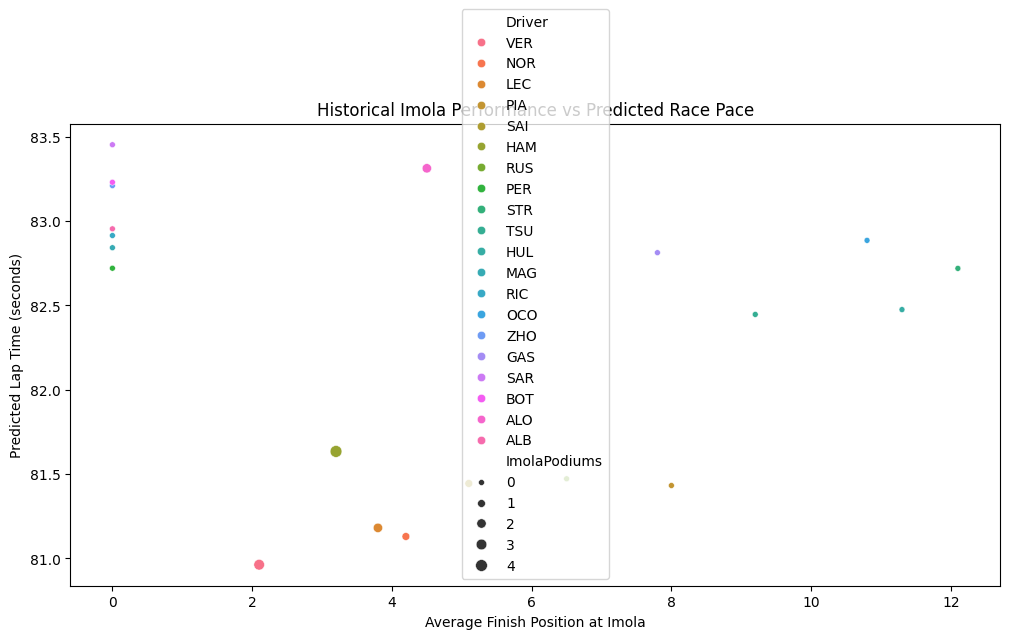

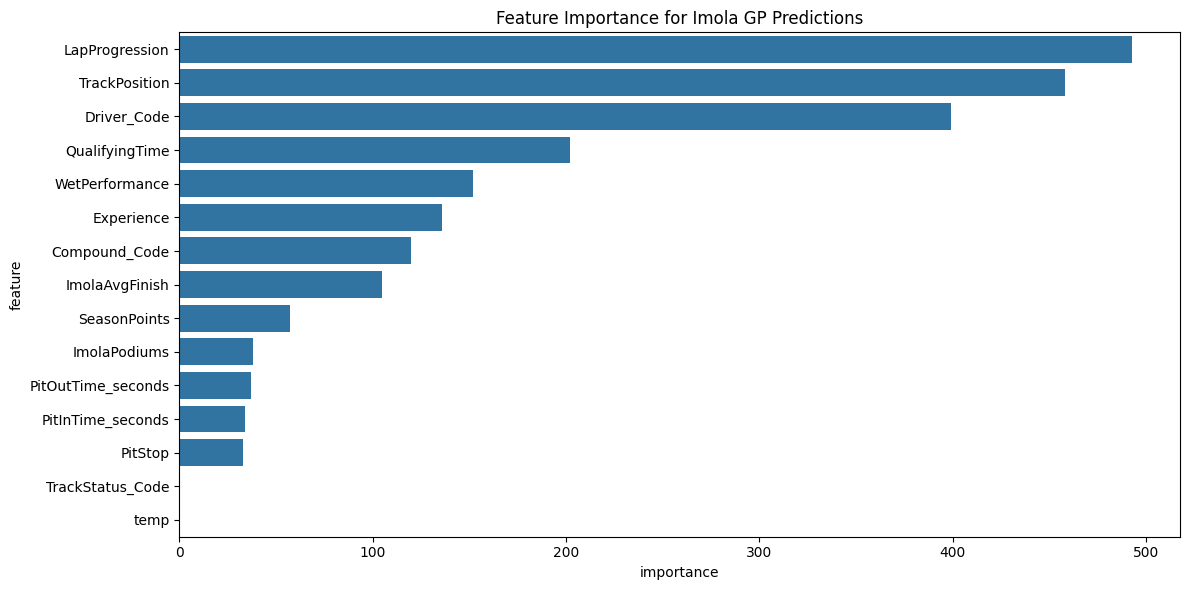


Predicted 2025 Emilia Romagna GP Results:
   Driver  Predicted_Race_Time  Historical_Avg_Finish  Imola_Podiums
8     NOR            81.334424                    4.2              1
18    VER            81.345367                    2.1              3
6     LEC            81.431590                    3.8              2
11    PIA            81.537372                    8.0              0
14    SAI            81.655766                    5.1              1
4     HAM            81.818425                    3.2              4
13    RUS            82.035467                    6.5              0
10    PER            82.140511                    0.0              0
16    STR            82.494435                   12.1              0
17    TSU            82.871831                    9.2              0


In [31]:
def main():
    # Load and prepare data
    historical_data = load_historical_data()
    lap_data = extract_features(historical_data)
    driver_features = create_driver_features()

    # Set Driver as index for easier lookup
    driver_features.set_index('Driver', inplace=True)

    # Weather data for Imola
    API_KEY = "YOUR_API_KEY"  # Replace with actual API key
    weather_data = get_weather_forecast(API_KEY)

    # Feature engineering specific to Imola
    feature_creator = CyclicalFeatures(variables=['TrackStatus'])
    scaler = StandardScaler()

    # Prepare features
    X = pd.merge(lap_data, driver_features.reset_index(), on='Driver', how='left')

    # Store original Driver names and create mappings
    original_drivers = X['Driver'].unique()
    driver_to_code = {driver: idx for idx, driver in enumerate(original_drivers)}
    code_to_driver = {idx: driver for driver, idx in driver_to_code.items()}

    # Create a lookup dictionary for driver features
    driver_stats = {}
    for driver in original_drivers:
        try:
            driver_stats[driver] = {
                'ImolaAvgFinish': driver_features.loc[driver, 'ImolaAvgFinish'],
                'ImolaPodiums': driver_features.loc[driver, 'ImolaPodiums']
            }
        except KeyError:
            print(f"Warning: No stats found for driver {driver}")
            driver_stats[driver] = {
                'ImolaAvgFinish': 0.0,
                'ImolaPodiums': 0
            }

    # Merge weather data if available
    if weather_data is not None:
        # Round datetime to hours for better matching
        X['datetime'] = pd.to_datetime(X['datetime']).dt.round('H')

        # Merge on closest datetime
        X = pd.merge_asof(X.sort_values('datetime'),
                         weather_data.sort_values('datetime'),
                         on='datetime',
                         direction='nearest',
                         tolerance=pd.Timedelta('3H'))
    else:
        # Add default weather columns if weather data is not available
        X['temp'] = 20.0
        X['humidity'] = 60.0
        X['wind_speed'] = 5.0
        X['rain_prob'] = 0.0

    # Drop datetime column as it's no longer needed
    X = X.drop('datetime', axis=1, errors='ignore')

    # Handle categorical and non-numeric columns
    # Convert Driver to numeric codes
    X['Driver_Code'] = X['Driver'].map(driver_to_code)

    # Convert TrackStatus to numeric
    X['TrackStatus_Code'] = pd.Categorical(X['TrackStatus']).codes

    # Convert tire compound to numeric
    X['Compound_Code'] = pd.Categorical(X['Compound']).codes

    # Convert pit times to seconds
    X['PitInTime_seconds'] = X['PitInTime'].dt.total_seconds().fillna(0)
    X['PitOutTime_seconds'] = X['PitOutTime'].dt.total_seconds().fillna(0)

    # Create target variable
    y = X['LapTime_seconds']

    # Select features for model
    feature_columns = [
        'Driver_Code', 'Compound_Code', 'TrackStatus_Code',
        'PitInTime_seconds', 'PitOutTime_seconds',
        'QualifyingTime', 'WetPerformance', 'SeasonPoints',
        'Experience', 'ImolaPodiums', 'ImolaAvgFinish',
        'TrackPosition', 'LapProgression', 'PitStop',
        'temp', 'humidity', 'wind_speed', 'rain_prob'
    ]

    # Keep only the features we want
    X = X[feature_columns]

    # Scale numerical features (excluding categorical codes)
    categorical_features = ['Driver_Code', 'Compound_Code', 'TrackStatus_Code']
    numerical_features = [col for col in X.columns if col not in categorical_features]
    X[numerical_features] = scaler.fit_transform(X[numerical_features])

    # Split data using time series split
    tscv = TimeSeriesSplit(n_splits=3)

    # Optimize model with Optuna
    study = optuna.create_study(direction='minimize')
    for train_idx, val_idx in tscv.split(X):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        study.optimize(lambda trial: objective(trial, X_train, y_train, X_val, y_val),
                      n_trials=30)

    # Train final model with best parameters
    best_params = study.best_params
    final_model = lgb.LGBMRegressor(**best_params)
    final_model.fit(X, y)

    # Make predictions for Emilia Romagna GP
    predictions = final_model.predict(X)

    # Prepare visualization data
    plot_data = pd.DataFrame({
        'Driver': [code_to_driver[code] for code in X['Driver_Code']],
        'Predictions': predictions,
        'ImolaAvgFinish': [driver_stats[code_to_driver[code]]['ImolaAvgFinish'] for code in X['Driver_Code']],
        'ImolaPodiums': [driver_stats[code_to_driver[code]]['ImolaPodiums'] for code in X['Driver_Code']]
    })

    # Visualize results
    plt.figure(figsize=(12, 6))
    sns.scatterplot(data=plot_data.drop_duplicates('Driver'),
                    x='ImolaAvgFinish',
                    y='Predictions',
                    hue='Driver',
                    size='ImolaPodiums')
    plt.title('Historical Imola Performance vs Predicted Race Pace')
    plt.xlabel('Average Finish Position at Imola')
    plt.ylabel('Predicted Lap Time (seconds)')
    plt.show()

    # Feature importance
    importance_df = pd.DataFrame({
        'feature': X.columns,
        'importance': final_model.feature_importances_
    }).sort_values('importance', ascending=False)

    plt.figure(figsize=(12, 6))
    sns.barplot(x='importance', y='feature', data=importance_df.head(15))
    plt.title('Feature Importance for Imola GP Predictions')
    plt.tight_layout()
    plt.show()

    # Print predictions
    unique_predictions = plot_data.groupby('Driver')['Predictions'].mean().reset_index()
    results = pd.DataFrame({
        'Driver': unique_predictions['Driver'],
        'Predicted_Race_Time': unique_predictions['Predictions'],
        'Historical_Avg_Finish': [driver_stats[driver]['ImolaAvgFinish'] for driver in unique_predictions['Driver']],
        'Imola_Podiums': [driver_stats[driver]['ImolaPodiums'] for driver in unique_predictions['Driver']]
    }).sort_values('Predicted_Race_Time')

    print("\nPredicted 2025 Emilia Romagna GP Results:")
    print(results[['Driver', 'Predicted_Race_Time', 'Historical_Avg_Finish', 'Imola_Podiums']].head(10))

if __name__ == "__main__":
    main()